In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
# valid columns when high speed
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150') # 0.386
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'RiskFactor', 'TimeHeadway') # 0.384
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision') # 0.382
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'RiskFactor') # 0.389
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'PathType', 'MinSpeed') # 0.382

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024, rpart.control=())
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp3.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [12]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 38/58 = 0.655172
As for Blue: correct/predict = 24/46 = 0.521739

Fold2
As for Red: correct/predict = 41/65 = 0.630769
As for Blue: correct/predict = 21/40 = 0.525000

Fold3
As for Red: correct/predict = 47/77 = 0.610390
As for Blue: correct/predict = 15/27 = 0.555556

Fold4
As for Red: correct/predict = 40/60 = 0.666667
As for Blue: correct/predict = 25/44 = 0.568182

Fold5
As for Red: correct/predict = 40/54 = 0.740741
As for Blue: correct/predict = 31/50 = 0.620000

Fold6
As for Red: correct/predict = 48/75 = 0.640000
As for Blue: correct/predict = 18/29 = 0.620690

Fold7
As for Red: correct/predict = 50/78 = 0.641026
As for Blue: correct/predict = 17/27 = 0.629630

Fold8
As for Red: correct/predict = 42/64 = 0.656250
As for Blue: correct/predict = 23/40 = 0.575000

Fold9
As for Red: correct/predict = 49/77 = 0.636364
As for Blue: correct/predict = 17/27 = 0.629630

Fold10
As for Red: correct/predict = 41/70 = 0.585714
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01002227

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AheadDistance   AverageVelocity BrakeCar        CurveAverage   
 [5] DistManBicycle  DistSignal      MaxSpeed        Pitch          
 [9] RiskFactor      Speed           TimeHeadway    

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.040831      0   1.00000 1.00000 0.035602
2 0.037862      3   0.87751 0.99332 0.035572
3 0.018931      4   0.83964 0.93318 0.035251
4 0.011136      8   0.76392 0.90869 0.035091
5 0.010022     14   0.68374 0.90646 0.035075
6 0.010000     18   0.64365 0.90646 0.035075


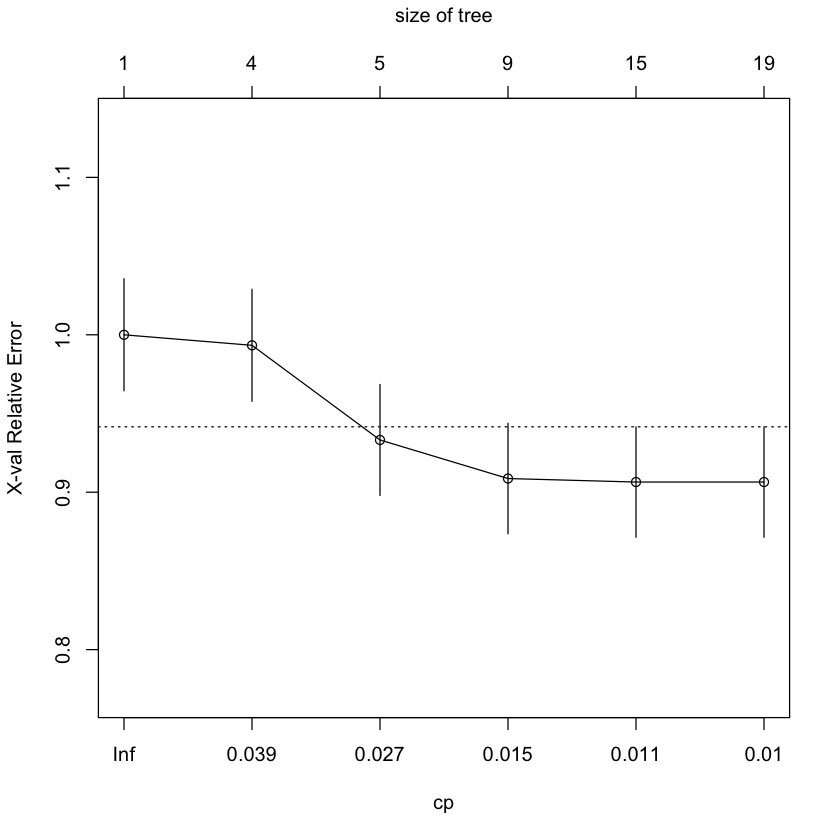

In [16]:
plotcp(fit3)

In [17]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.04083148      0 1.0000000 1.0000000 0.03560167
2 0.03786192      3 0.8775056 0.9933185 0.03557217
3 0.01893096      4 0.8396437 0.9331849 0.03525095
4 0.01113586      8 0.7639198 0.9086860 0.03509090
5 0.01002227     14 0.6837416 0.9064588 0.03507550
6 0.01000000     18 0.6436526 0.9064588 0.03507550

Variable importance
            Speed   AverageVelocity       TimeHeadway          MaxSpeed 
               13                12                11                11 
    AheadDistance        RiskFactor      CurveAverage          RoadType 
                9                 8                 6                 6 
            Curve            Engine             Pitch        DistSignal 
                4                 4                 3                 2 
    SteeringAngle    DistManBicycle        ManBicycle   ManBicycleCount 
                2                 2      

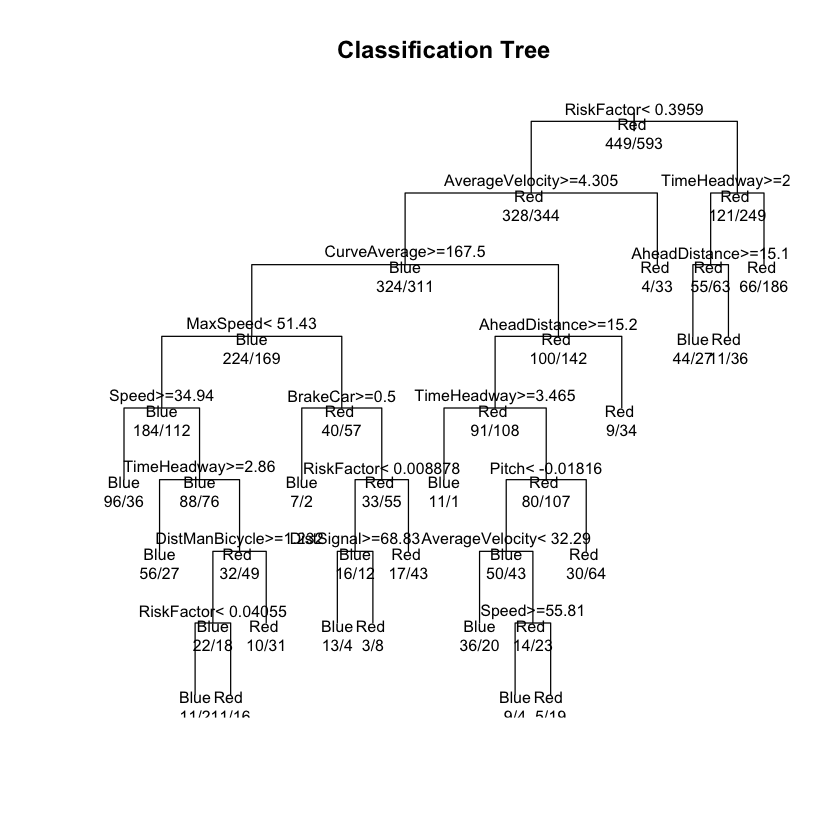

In [18]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)